In [44]:
import os
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [60]:
chips_df = pd.read_csv('../input/chips.csv')
geyser_df = pd.read_csv('../input/geyser.csv')

X_chips = chips_df.drop('class', axis=1)
y_chips = chips_df['class'].map({'P' : 1, 'N': -1})
X_geyser = geyser_df.drop('class', axis=1)
y_geyser = geyser_df['class'].map({'P' : 1, 'N': -1})

In [132]:
class AdaBoost:
    def __init__(self, n_trees):
        self.n_trees = n_trees
        self.trees = []
        self.tree_weights = []
        
    def plot_sample(self, X, y, predicted, grid, grid_predicted, title=''):
        df = X.copy()
        df['label'] = pd.Series(y).map({1: 'P', -1: 'N'})
        df['size'] = 100.
        grid_df = grid.copy()
        grid_df['label'] = pd.Series(grid_predicted).map({1: 'P', -1: 'N'})
        grid_df['size'] = 1.
        palette = {'P': 'firebrick', 'N': 'dodgerblue'}
        ax = sns.scatterplot(data=grid_df, x='x', y='y', hue='label', s=10, alpha=.3, palette=palette, legend=False)
        ax2 = sns.scatterplot(data=df, x='x', y='y', hue='label', s=40, alpha=1., palette=palette, ax=ax)
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5)).set(title=title)
        plt.show()
        
    def plot_accuracy(self, acc_list):
        df = pd.DataFrame()
        df['step'] = [x[0] for x in acc_list]
        df['accuracy'] = [x[1] for x in acc_list]
        sns.lineplot(data=df, x='step', y='accuracy')
        
    def predict(self, X):
        y_pred = np.array([tree.predict(X) for tree in self.trees])
        return np.sign(np.dot(self.tree_weights, y_pred))

    def fit(self, X, y, steps=[]):
        m = y.shape[0]
        weights = np.full(m, 1. / m)
        self.trees = []
        self.tree_weights = []
        trees_pool = []
        acc_list = []
        for t in range(self.n_trees):
            clf = DecisionTreeClassifier(max_depth=3)
            clf.fit(X, y, sample_weight=weights)
            trees_pool.append(clf)
            scores = [1 - tree.score(X, y, sample_weight=weights) for tree in trees_pool]
            best_tree_index = np.argmin(scores)
            clf = trees_pool[best_tree_index]
            eps = scores[best_tree_index]
            pred = clf.predict(X)            
            clf_weight = 0.5 * np.log((1 - eps) / (eps + 1e-27))
            weights = weights * np.exp(-clf_weight * y * clf.predict(X))
            weights /= weights.sum()
            self.trees.append(clf)
            self.tree_weights.append(clf_weight)
            predicted = self.predict(X)
            acc_score = accuracy_score(y, predicted)
            acc_list.append((t, acc_score))
            if t + 1 in steps:
                x_min, x_max = np.min(X['x']), np.max(X['x'])
                y_min, y_max = np.min(X['y']), np.max(X['y'])
                border_factor = 50.
                grid_len = 100.
                x_min -= x_min / border_factor
                y_min -= y_min / border_factor
                x_max += x_max / border_factor
                y_max += y_max / border_factor
                delta_x = (x_max - x_min) / grid_len
                delta_y = (y_max - y_min) / grid_len
                grid_matrix = [[_x, _y] for _x in np.arange(x_min, x_max, delta_x) for _y in np.arange(y_min, y_max, delta_y)]
                grid_X = pd.DataFrame(data=grid_matrix, columns=['x', 'y'])
                grid_predicted = self.predict(grid_X)
                self.plot_sample(X, y, predicted, grid_X, grid_predicted, f'Step {t + 1}, accuracy: {np.round(acc_score, 3)}')
        self.tree_weights = np.array(self.tree_weights)
        return acc_list

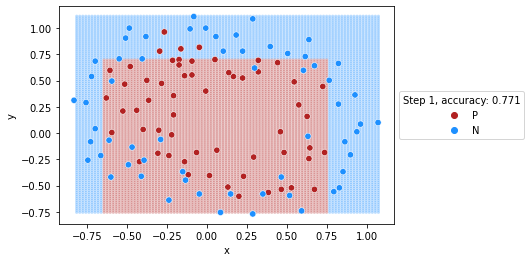

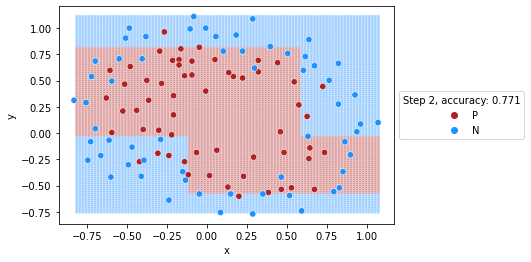

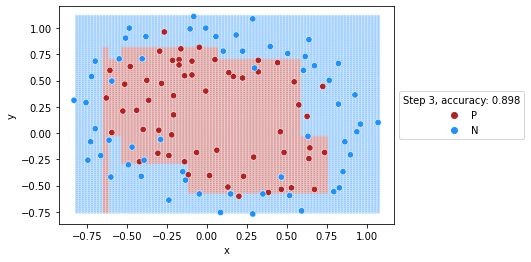

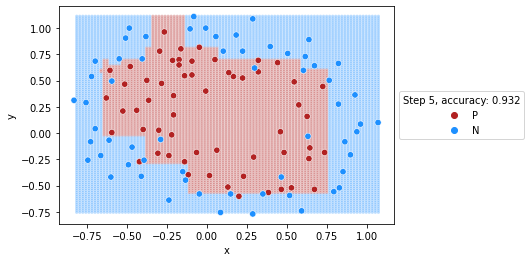

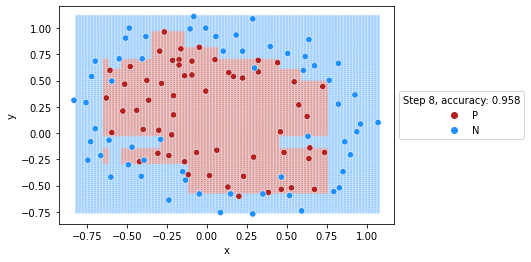

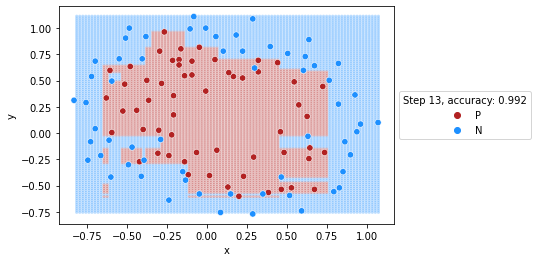

KeyboardInterrupt: 

In [137]:
boost = AdaBoost(55)
acc_list = boost.fit(X_chips, y_chips, steps=[1, 2, 3, 5, 8, 13, 21, 34, 55])

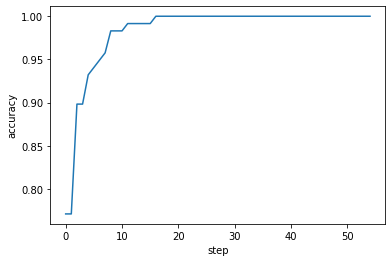

In [134]:
boost.plot_accuracy(acc_list)

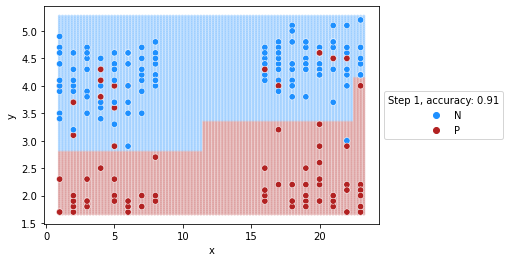

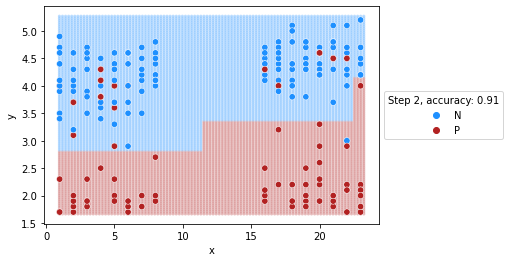

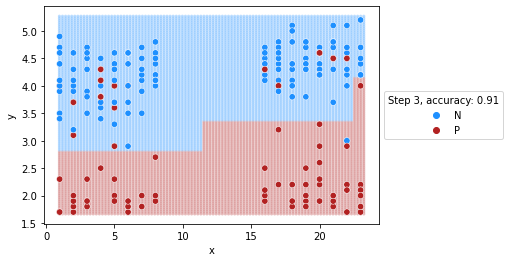

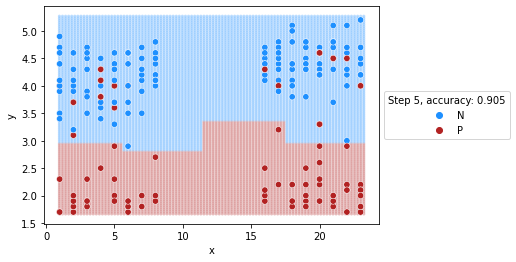

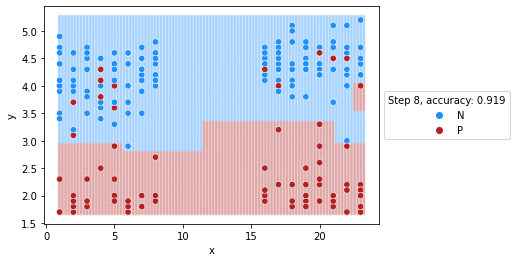

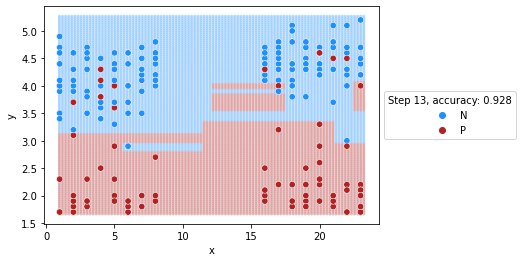

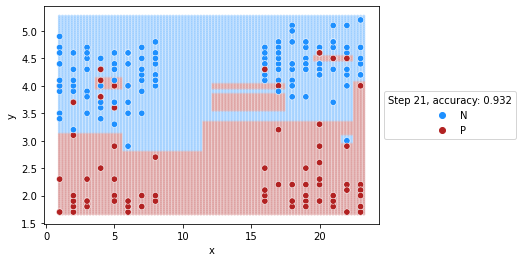

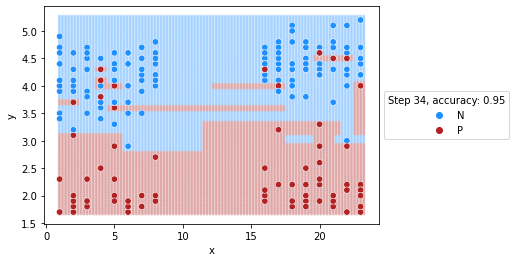

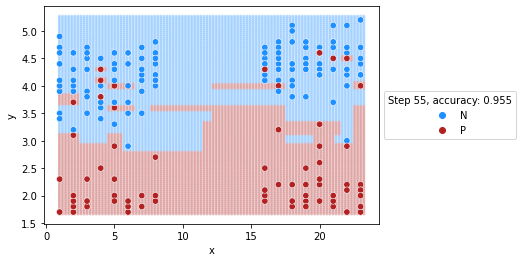

In [138]:
boost = AdaBoost(55)
acc_list = boost.fit(X_geyser, y_geyser, steps=[1, 2, 3, 5, 8, 13, 21, 34, 55])

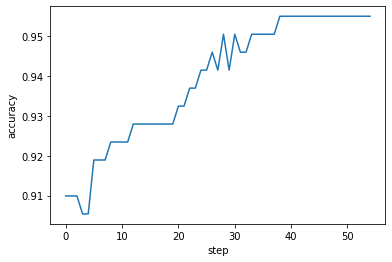

In [139]:
boost.plot_accuracy(acc_list)